In [1]:
import dpaleo
import matplotlib.pyplot as plt
import numpy as np

# An implemention of the UCERF3 workflow for NZ-NSHM2022.


The following is an informal implementation of the workflow developed by Weldon and Biasi (2013). The workflow is neat and straightforward. We decribe each step as follow. 


###  1. What is probability that the event is (observable) surface-rupture event?
The probability of an earthquake being a surface-rupture event may not be merely a function of magnitude. It could very well depend on other factors such as location of hypocenter, dip of the fault, and type-of-faulting. However, the magnitude-dependence is reasonable not only for its simplicity but also considering region-specific nature of application.

The following uses a NZ-specific model.

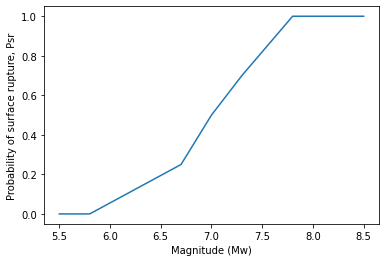

In [2]:
dpaleo.plot_prob_detectsurfrup(model="NZ_SurfaceRuptureProbability.csv")  

Figure 1. A New Zealand model for the probability of an event (in terms of magnitude) having observable surface rupture.

###  2. What is the average surface slip?

To determnine rupture area, we employ simplied magnitude-area scaling specific for strike-slip faulting type (Striling et al., 2021). 

A = 10^(magnitude-4.2)*1000*1000

We determine the seismic moment based on the relation given by Hanks and Kanamori(1979) as follow, 

Mo =  10^(1.5*magnitude+9.05) 

Considering crustal rigidity, \Mu = 3.0x10^10 Nm^-2 and using Aki (1966)'s relation, we get the average slip as follow,

D = Mo/(A*\mu) 

We consider D_surface = D, in the light of Thingbaijam et al. (2022)'s observation that average surface slip and overall average slip are comparable. 


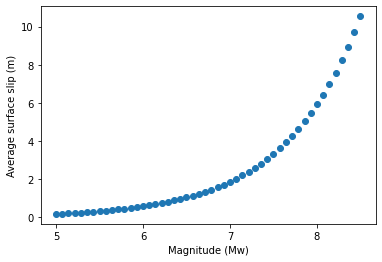

In [3]:
dpaleo.plot_mag2avg_surfslip(model="NZNSHM22")

Figure 2. Relation between magniude and average surface slip

###  3. What is the slip profile on the fault?

The average surface slip is distributed according to a sinesqrt function.

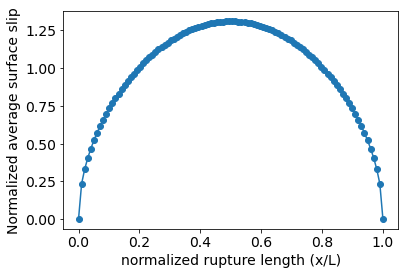

In [4]:
dpaleo.plot_sinesqrt()

Figure 3. Normalized along-strike slip profile

###  4. What is distribution of normalized average surface slip at an along-strike point on the fault-rupture?

UCERF3 applies lognormal distribution. Here, we use generalized extreme value (GEV) distribution (Thingbaijam et al., 2022). The following is an example of GEV distribution

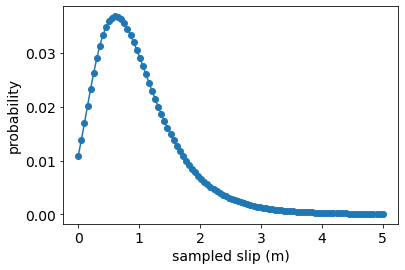

In [5]:
sampledslip, sampledslipprob = dpaleo.prob_slip_profpoint (1, xi=0.2, model = "GEV", normalized = True)

plt.plot(sampledslip, sampledslipprob, 'o-')
plt.xlabel('sampled slip (m)');
plt.ylabel('probability');

Figure 4. An example depicting GEV distribution of normalized average slip at a point along strike of fault-rupture

#### It might be useful to understand the implication of probability distribution function (PDF).

We consider integration over PDF through summation,
<br></br>
$P_{TD, total}$($u_{x}$) = $\sum_{i=1}^{n}$ $P_{tD}$($u_{x,i}$) $P_{x}$($u_{xi}$) &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(1)
<br></br>
which gives the probability of detecting slip ($u_{x}$) at the trench ( or detectability of paleo-slip) for surface-rupture event

### 5. What is the probability of detecting paleo-slip at the trench?

THe figure given below is what I refer to as "The Wrightwood model" (Table from UCERF Appendix I). UCERF3 employs linear interpolation on these data points as is in this workout. However, I believe an exponential model can be easily formulated which would just do fine.

We still have to consider the proability of being a surface-rupture event. Complete formulation is as follows:
<br></br>
$P_{paleoslip}$($u_{x}$) = $\sum_{i=1}^{n}$ $P_{tD}$($u_{x,i}$) $P_{x}$($u_{xi}$) $P_{SR}$ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;    (2)
<br></br>

which gives the detectability of ground-rupture at paleoseismic sites.



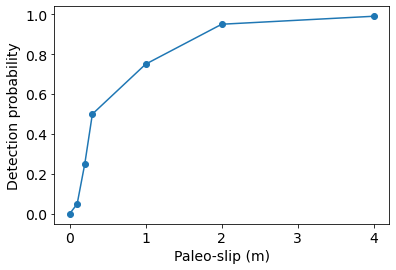

In [6]:
dpaleo.plot_prob_detect_paleoslip(model="wrightwood2013")

Figure 5. The Wrightwood model for probabilty of detecting slip at paleoseismic site. 


An exponential model fits the Wrightwood observations quite nicely, which is given by p = 1-np.exp(-1.6*u), where p is probability of dectecting paleo-slip while u is slip (in m).However, UCERF3 uses 1-D interpolation.



In [ ]:
def compute_prob_detectpaleoslip(mag, norm_x =np.linspace(0.00001, 0.5,50)):
    # get prob of being observble surface-rupture event
    # norm_x in theory can start at 0 but I get a divide by zero warning (not error) ..
    
    P_sr = dpaleo.prob_detectsurfrup(magnitude=mag, model="NZ_SurfaceRuptureProbability.csv")

    # get average surface slip
    avg_surfslip = dpaleo.mag2avg_surfslip(magnitude=mag, model="NZNSHM22")

    # get surface slip profile
    slip_x = dpaleo.slip_profile(avg_surfslip, x_by_RL=norm_x, model="sinesqrt")
    prob_paleo_detect = []

    # slip_x is slip profile
    for ii in range(len(slip_x)): 
        sampledslip, slipprob = dpaleo.prob_slip_profpoint(slip_x[ii], xi=norm_x[ii], model = "GEV", normalized = True)
    
        prob_td_x = [] # prob of being detectable at the paleo trench
        for jj in range(len(sampledslip)):
            # model="wrightwood2013"
            temp = dpaleo.prob_detectpaleoslip(sampledslip[jj], prob_sampledslip = slipprob[jj])
            prob_td_x.append(temp)
    
        prob_td = sum(prob_td_x)
        prob_paleo_detect.append(prob_td*P_sr)
        
    return (norm_x, prob_paleo_detect, avg_surfslip)

In [ ]:
mag = np.arange(5.0, 9.01, 0.05)
for m in mag:
    norm_x, prob_paleo_detect, AD = compute_prob_detectpaleoslip(m)
    plt.plot(norm_x, prob_paleo_detect, '--', color = [0.5, 0.5, 0.5])  
    
mag = [6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.01]
#mag = np.arange(5.0, 8.25, 0.05)
for m in mag:
    norm_x, prob_paleo_detect, AD = compute_prob_detectpaleoslip(m)
    plt.plot(norm_x, prob_paleo_detect, 'r-')

plt.xlim([0.0, 0.5])
plt.ylim([0.0, 1.0])
plt.xlabel('normalized rupture length (x/L)');
plt.ylabel('Probability');


Figure 6. Probability for detectability of ground-rupture at paleoseismic sites. The lines corresponds to different earthquake magnitudes, and those in red corresponds to magnitudes: Mw 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, and 9.0 in order of the increasing probability.




In [ ]:
# let us create the Table similar to Table I2 of Appendix I of UCERF3 report
mag = np.arange(5.0, 9.01, 0.05)

norm_x = np.array([0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.000000001])

print("M AD(M) 0.5 0.45 0.4 0.35 0.3 0.25 0.2 0.15 0.1 0.05 0.0")

out = []
for m in mag:
    tout = []
    norm_x, prob_paleo_detect, AD = compute_prob_detectpaleoslip(m, norm_x = norm_x)
    tout.append(round(m,2))
    tout.append(round(AD,3))
    for pi in prob_paleo_detect:
        tout.append(round(pi, 6))
    print(*tout,'    ')
    out.append(tout)

# write out a .csv file

import csv 

# open the file in the write mode
f = open('PoD_NZNSHM2022.csv', 'w')

# create the csv writer
writer = csv.writer(f)
writer.writerow(['M','AD(M)',0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0])
for row in out:
    # write a row to the csv file
    writer.writerow(row)

# close the file
f.close()
    

#### Reference:

Thingbaijam  KKS,  Van  Dissen  RJ,  Shaw  BE,  Gerstenberger  MC. 2022. Average coseismic slip profiles. Lower Hutt (NZ): GNS Science.33p.(GNS Science report;2021/24). doi:10.21420/S6ED-JN06

Weldon RJ, Biasi GP. Appendix I: Probability of detection of ground rupture at paleoseismic sites.  US Geol. Surv. Open‐File Rept. 2013‐1165‐I, and California Geol. Surv. Special Rept. 228‐I. 2013.
 
 -----------------------------------------------------------------------------------